In [1]:
from datetime import datetime

#import pyodbc
import sqlalchemy
#import sqlalchemy as msql
#import Connexion_bdd as Cx_bdd
import numpy as np
import pandas as pd
import Requetes_SQL as Req_SQL
import matplotlib.pyplot as plt
import seaborn as sns
#import dtw as dtw
#import tsfresh #TimeSeries Transformation library
import my_custom_func_TS_Clust_1 as Mcftsc
import mlflow

from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics, tree

#SET THE RANDOM SET FOR SKLEARN
#np.random.seed(0)

In [2]:
#Project Classes
#import FSQL_Classes as FSQLC
import Sql_Alchemy_Classes as AlSQL
#import Parcours_Classes as PC

2023-12-13 21:42:56,508 INFO sqlalchemy.engine.Engine SELECT CAST(SERVERPROPERTY('ProductVersion') AS VARCHAR)
2023-12-13 21:42:56,509 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-12-13 21:42:56,510 INFO sqlalchemy.engine.Engine SELECT schema_name()
2023-12-13 21:42:56,510 INFO sqlalchemy.engine.Engine [generated in 0.00036s] ()
2023-12-13 21:42:56,512 INFO sqlalchemy.engine.Engine SELECT CAST('test max support' AS NVARCHAR(max))
2023-12-13 21:42:56,512 INFO sqlalchemy.engine.Engine [generated in 0.00033s] ()
2023-12-13 21:42:56,513 INFO sqlalchemy.engine.Engine SELECT TOP (10) [idUFX_Ress_Equ] FROM [ICO_Activite].[dbo].[Listing_UF_V3]
2023-12-13 21:42:56,513 INFO sqlalchemy.engine.Engine [raw sql] ()
Connexion BDD - OK


In [3]:
#ML FLOW Configuration

# LAUNCH ML FLOW UI
#!mlflow server --host 127.0.0.1 --port 8080
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Set an experiment name, which must be unique and case-sensitive.
experiment = mlflow.set_experiment("Clustering parcours_V2")
mlflow.set_experiment_tag("release.version", "0.1")

# Get Experiment Details
print(f"Experiment_id: {experiment.experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")
print(f"Tags: {experiment.tags}")
print(f"Lifecycle_stage: {experiment.lifecycle_stage}")

# Launch a run into the experiment
mlflow.start_run()

Experiment_id: 715714748593750550
Artifact Location: mlflow-artifacts:/715714748593750550
Tags: {'release.version': '0.1'}
Lifecycle_stage: active


<ActiveRun: >

### Get the data

In [4]:
Create_dataset_parameters={'DS_My_NIP_filter_1rst_date': '01-01-2019 00:00:00',
                            'DS_My_NIP_filter_2nd_date_delta_in_days': 2,
                            'DS_Site': '2',
                            'DS_Start_Window_time': '01-09-2018 00:00:00',
                            'DS_End_Window_time': '12-31-2020 00:00:00',
                            }
myouputpath='../06 - Temp_outputs/'

In [5]:
mlflow.log_params(Create_dataset_parameters)

In [6]:
Caracteristiques_Dataset=Mcftsc.Create_dataset(Create_dataset_parameters)

STEP 1.0 : Delete old Tables
2023-12-13 21:42:56,790 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-13 21:42:56,791 INFO sqlalchemy.engine.Engine EXECUTE dbo.Delete_Table_if_exists Tmp_Py_A_Actes_Export
2023-12-13 21:42:56,791 INFO sqlalchemy.engine.Engine [generated in 0.00067s] ()
2023-12-13 21:42:56,793 INFO sqlalchemy.engine.Engine COMMIT
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-01-01 00:00:00 - Date2  = 2019-01-03 00:00:00 - launched at 2023-12-13 21:42:56.795135
2023-12-13 21:42:56,795 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-13 21:42:56,795 INFO sqlalchemy.engine.Engine  EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE_AND_DATASET_ON_2_DATES A_Actes_ICO_2018_2021_V2_TRIMED,Tmp_Py_A_Actes_Export,'2019-01-01 00:00:00','2019-01-03 00:00:00','2018-01-09 00:00:00','2020-12-31 00:00:00',2
2023-12-13 21:42:56,796 INFO sqlalchemy.engine.Engine [generated in 0.00088s] ()
2023-12-13 21:42:57,685 INFO sqlalchemy.engine.Engine COMMIT
STEP 1.2 : Prepare_Dat

In [7]:
# Create the DataFrame
df = pd.DataFrame.from_dict(Caracteristiques_Dataset)

# Convert specified columns to dictionary
mydict = df.iloc[:, 6:].to_dict(orient='list')

# Filter dictionary to contain only float values and not lists
for key, value in mydict.items():
    if len(value) == 1 :
        mydict[key] = value[0]

mlflow.log_metrics(mydict)

In [8]:
#Get all actes in the Dataset

Requete = """
  SELECT *
  FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]
  """
  
Actes_Total=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,True) #FSQLC.F_SQL_Requete(FSQLC.cnxn,Requete,FSQLC.pyodbc,'No')
Actes_Total


2023-12-13 21:43:13,102 INFO sqlalchemy.engine.Engine 
  SELECT *
  FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]
  
2023-12-13 21:43:13,103 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


ID_A         NIP       N_S       DD_A       DF_A       DD_M  \
0       14483440  N201803896  N1919596 2020-02-20 2020-02-20 1899-12-30   
1       14483441  N201803896  N1919596 2020-02-20 2020-02-20 1899-12-30   
2       14483442  N201803896  N1919596 2020-02-20 2020-02-20 1899-12-30   
3       14483443  N201803896  N1919596 2020-02-20 2020-02-20 1899-12-30   
4       14483444  N201803896  N1919596 2020-02-20 2020-02-20 1899-12-30   
...          ...         ...       ...        ...        ...        ...   
172047  15119813  N201704974  N2111214 2020-10-27 2020-10-27 1899-12-30   
172048  15119814  N201704974  N2111214 2020-10-27 2020-10-27 1899-12-30   
172049  15326825  N201304295  N1974878 2020-02-05 2020-02-05 1899-12-30   
172050  15326826  N201304295  N1974878 2020-02-05 2020-02-05 1899-12-30   
172051  15172007  N201601143  N2096875 2020-10-01 2020-10-01 1899-12-30   

             HD_M       DF_M       HF_M   UFX  ... AC_Asso Lc_Prix UFH UFH_L  \
0      1899-12-30 1899-12-30 1899-12-30  1933  ...       0    0.27             
1      1899-12-30 1899-12-30 1899-12-30  1933  ...       0    0.27             
2      1899-12-30 1899-12-30 1899-12-30  1933  ...       0    0.27             
3      1899-12-30 1899-12-30 1899-12-30  1933  ...       0    0.27             
4      1899-12-30 1899-12-30 1899-12-30  1933  ...       0    0.27             
...           ...        ...        ...   ...  ...     ...     ...  ..   ...   
172047 1899-12-30 1899-12-30 1899-12-30  9018  ...       0    0.27             
172048 1899-12-30 1899-12-30 1899-12-30  9018  ...       0    0.27             
172049 1899-12-30 1899-12-30 1899-12-30  1933  ...       0    0.27             
172050 1899-12-30 1899-12-30 1899-12-30  1933  ...       0    0.27             
172051 1899-12-30 1899-12-30 1899-12-30  1933  ...       0    0.27             

       Prix_Acte Cout_Acte Statut Code_Equip Site Source  
0                               H               2   NGAP  
1                               H               2   NGAP  
2                               H               2   NGAP  
3                               H               2   NGAP  
4                               H               2   NGAP  
...          ...       ...    ...        ...  ...    ...  
172047                          E               2   NGAP  
172048                          E               2   NGAP  
172049                          E               2   NGAP  
172050                          E               2   NGAP  
172051                          E               2   NGAP  

[172052 rows x 32 columns]

AFFICHAGE DES PARCOURS COMPLETS DES PATIENTS SELECTIONNES

In [9]:
#import importlib
#importlib.reload(Mcftsc)

2023-12-13 21:43:15,453 INFO sqlalchemy.engine.Engine SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  --WHERE Table_Cluster.NIP = Table_Acte.NIP

2023-12-13 21:43:15,453 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


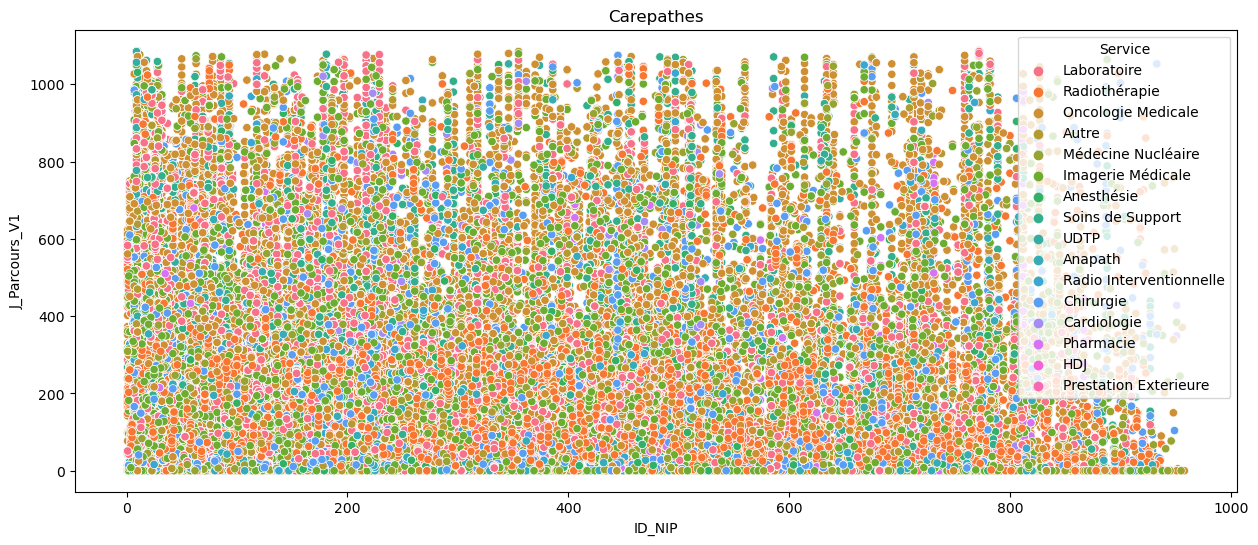

In [10]:
#Recuperer une table acte pour affichage
Requete="""SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  --WHERE Table_Cluster.NIP = Table_Acte.NIP
"""
df_Actes_graph=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')

Mcftsc.plot_carepath(df_Actes_graph,myouputpath+ 'Actes_total.png')
mlflow.log_artifact(myouputpath+'Actes_total.png', "DS_General_plot")

AFFICHAGE DES PARCOURS RADIOTHERAPIE DES PATIENTS

2023-12-13 21:43:25,309 INFO sqlalchemy.engine.Engine SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  WHERE Table_Acte.[Service] = 'Radiothérapie'

2023-12-13 21:43:25,310 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


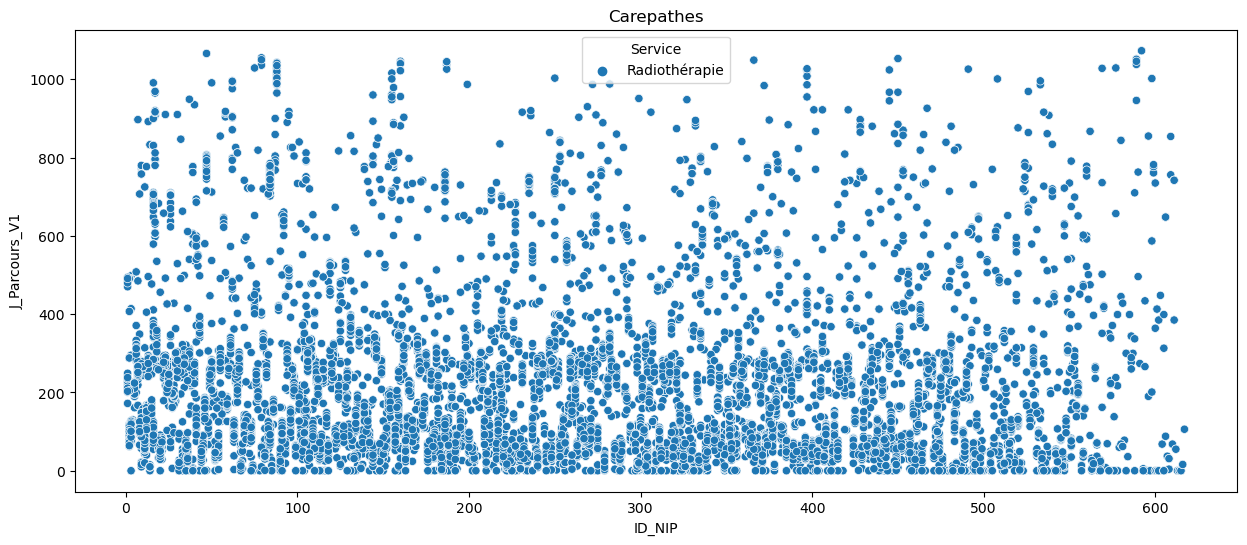

In [11]:
#Recuperer une table acte pour affichage
Requete="""SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  WHERE Table_Acte.[Service] = 'Radiothérapie'
"""
df_Actes_graph0=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')

myoutputfile='Actes_rdth.png'
Mcftsc.plot_carepath(df_Actes_graph0,myouputpath + 'Actes_rdth.png')
mlflow.log_artifact(myouputpath + 'Actes_rdth.png', "DS_General_RDTH_plot")

APPLICATION D'UNE FONCTION D'AGGREGATION:

# creation d'un dictionnaire pour la requete

Aggreg_parameters
    #PARAM1 = CHOICE = 
       	#-- 0 : REPORT DAYLY turnover from stardate of calendar (1 column = 1 DAY), CURSOR LINES ARE DAYS
		#-- 1 : REPORT WEEKLY turnover from stardate of calendar  (1 column = 1 WEEK), CURSOR LINES ARE WEEKS
		#-- 2 : REPORT MONTHLY turnover from stardate of calendar  (1 column = 1 month), CURSOR LINES ARE MONTHS
		#-- 3 : REPORT TRIMESTER turnover for the @YEAR (1 column = 3 months), CURSOR LINES ARE TRIMESTERS
		#-- 4 : REPORT ALL YEAR turnovers (1 column = 1 Year), CURSOR LINES ARE YEARS
    'Report_type': '2',  #--1

    #PARAM2 'TYPE AGGREG' --PARAMETER 3: @AggParameter as nvarchar(20)
		#--CALENDAR : Par date calendaire
		#--PARCOURS : Par date de parcours
    'Aggreg_type': 'PARCOURS',

    #Date ref
    'Date_ref' : "''",

    #0 --PARAMETER 4 : @AggParameter_min as int (NB jours)
    'Start_at_item': '0',

    #50 --PARAMETER 5 : @AggParameter_max as int (NB jours)
    'Stop_at_item': '36', # --104

    #'PRESENCE'	-- PARAMETER 4 : @AggMeth as nvarchar(20) --OK
		#--PRESENCE : -> FUNCTION COUNT
		#--COUNT -> FUNCTION SUM
		#--DENSITE -> Function SUM / Length of aggregation choice (1, 7, 30.41 , 365.25)
    'Method': 'COUNT',

    #'3'	-- PARAMETER 5  @Filter1_type as nvarchar(20
          #--0-ALL
          #--1-SERVICE -> from Listing_UF_V3
          #--2-ACTIVITE -> from Listing_UF_V3
          #--3-PHASE PARCOURS -> from Listing_UF_V3
          #--4-DIMENSION PARCOURS -> from Listing_UF_V3
          #--5-POIDS ACTE -> from Listing_UF_V3
          #--6-TYPE DE SEQUENCE -> from Tmp_Type_Seq
          #--7-TYPE DE PARCOURS-- -> (After Clustering only)
          #--8-R_NGAP
          #--9-R_CCAM
          #--10-Statut
          #--11-UFH
          #--12-INX

    'Type_filter1': '6',
    'Val_filter1': 'TRAIT', #Filter value,
    #'3'	-- PARAMETER 5  @Filter1_type as nvarchar(20)
    'Type_filter2': '1',
    'Val_filter2': 'Radiothérapie', #Filter value

    #J0
      #--V1
      #--V2
      #--V3
      #--V4"""
    'Param_J0':'V3'

In [12]:
Aggreg_parameters={'Report_type': '2',
                            'Aggreg_type': 'PARCOURS',
                            'Date_ref': "''",
                            'Start_at_item': '0',
                            'Stop_at_item': '24',
                            'Method': 'COUNT',
                            'Type_filter1': '6',
                            'Val_filter1': 'TRAIT',
                            'Type_filter2': '1',
                            'Val_filter2': 'Radiothérapie',
                            'Param_J0': 'V3',
                            }
#Tmp_Carac_Actes
#Tmp_A_Actes_Table_Analyse

Aggreg_parameters_TT_RDTH=Aggreg_parameters.copy()
Aggreg_parameters_TT_RDTH['Val_filter2']= 'Radiothérapie'

Aggreg_parameters_TT_CHIR=Aggreg_parameters.copy()
Aggreg_parameters_TT_CHIR['Val_filter2']= 'Chirurgie'

Aggreg_parameters_TT_CHIMIO=Aggreg_parameters.copy()
Aggreg_parameters_TT_CHIMIO['Val_filter2']= 'Oncologie Medicale'

Aggreg_parameters_TT_UDTP=Aggreg_parameters.copy()
Aggreg_parameters_TT_UDTP['Val_filter2']= 'UDTP'

Aggreg_parameters_TT_MN=Aggreg_parameters.copy()
Aggreg_parameters_TT_MN['Val_filter2']= 'Médecine Nucléaire'

Aggreg_parameters_TT_RI=Aggreg_parameters.copy()
Aggreg_parameters_TT_RI['Val_filter2']= 'Radio Interventionnelle'

Aggreg_parameters_TT_autre=Aggreg_parameters.copy()
Aggreg_parameters_TT_autre['Val_filter2']= 'Autre'


Aggreg_parameters_SUIVI_CT_CS=Aggreg_parameters.copy()
Aggreg_parameters_SUIVI_CT_CS['Val_filter1']= 'SUIVI_CT'
Aggreg_parameters_SUIVI_CT_CS['Type_filter2']= '3'
Aggreg_parameters_SUIVI_CT_CS['Val_filter2']= 'Consultation'

Aggreg_parameters_SUIVI_LT_CS=Aggreg_parameters.copy()
Aggreg_parameters_SUIVI_LT_CS['Val_filter1']= 'SUIVI_LT'
Aggreg_parameters_SUIVI_LT_CS['Type_filter2']= '3'
Aggreg_parameters_SUIVI_LT_CS['Val_filter2']= 'Consultation'

Aggreg_parameters_INIT_NEW_CS=Aggreg_parameters.copy()
Aggreg_parameters_INIT_NEW_CS['Val_filter1']= 'INIT_NEW'
Aggreg_parameters_INIT_NEW_CS['Type_filter2']= '3'
Aggreg_parameters_INIT_NEW_CS['Val_filter2']= 'Consultation'

Aggreg_parameters_INIT_OLD_CS=Aggreg_parameters.copy()
Aggreg_parameters_INIT_OLD_CS['Val_filter1']= 'INIT_OLD'
Aggreg_parameters_INIT_OLD_CS['Type_filter2']= '3'
Aggreg_parameters_INIT_OLD_CS['Val_filter2']= 'Consultation'


In [13]:
import importlib
importlib.reload(Mcftsc)

#Aggreg_Patients=Mcftsc.get_Aggreg_Dataset(Aggreg_parameters_TT_RDTH,Aggreg_parameters_TT_CHIMIO,Aggreg_parameters_TT_CHIR)

Parameters_list=[Aggreg_parameters_TT_RDTH
                 ,Aggreg_parameters_TT_CHIMIO
                 ,Aggreg_parameters_TT_CHIR
                 ,Aggreg_parameters_TT_UDTP
                 ]

Parameters_list=[Aggreg_parameters_TT_RDTH
                 ]

Aggreg_Patients=Mcftsc.get_Aggreg_Dataset2(Parameters_list)

for param in Parameters_list:
    mlflow.log_params(param)

Aggreg_Patients['Nb_dim']

Number of aggregation dimensions: 1
2023-12-13 21:43:26,549 INFO sqlalchemy.engine.Engine EXECUTE [dbo].[ReportCarePathActivtiy_By_actes] 2,'PARCOURS','',0,24,'COUNT',6,'TRAIT',1,'Radiothérapie','V3'
2023-12-13 21:43:26,549 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


'1'

CREATION DE COURBES CARACTERISTIQUES DE PARCOURS

0 - Courbe en l'état, présence au cours de l'aggrégat temporel.
1 - CUMUL DU NB DE SEJOURS DE TT RDTH, CHIR OU CHIMIO au cours du temps
2 - Moyenne mobile sur (x mois/semaine) du nb de sejour de tt de RDTH, CHIR OU CHIMIO


In [14]:
#AJOUTER ICI SI BESOIN UNE FONCTION DE POSTRAITEMENT DU DATASET AGGREG (F.Ex : MOBILE AVERAGE)

In [15]:
Aggreg_Patients['df'].to_csv(myouputpath + 'Agg_Pat.csv')
mlflow.log_artifact(myouputpath + 'Agg_Pat.csv', "Aggreg_Dataset")

In [16]:
dist_matrix=Mcftsc.GetDistanceMatrix(Aggreg_Patients, Aggreg_parameters)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Iteration 0/957 - Temps restant estimé: 4.50 minutes
Iteration 100/957 - Temps restant estimé: 4.03 minutes
Iteration 200/957 - Temps restant estimé: 3.26 minutes
Iteration 300/957 - Temps restant estimé: 2.64 minutes
Iteration 400/957 - Temps restant estimé: 2.10 minutes
Iteration 500/957 - Temps restant estimé: 1.62 minutes
Iteration 600/957 - Temps restant estimé: 1.18 minutes
Iteration 700/957 - Temps restant estimé: 0.79 minutes
Iteration 800/957 - Temps restant estimé: 0.44 minutes
Iteration 900/957 - Temps restant estimé: 0.14 minutes
Durée totale de traitement: 140.48 secondes


In [17]:
#EXPORT DE LA MATRICE DE DISTANCE
#dist_matrix.tofile(myouputpath + "Matrice_distance.dat")
np.savetxt(myouputpath + "distance_matrix.csv",dist_matrix,delimiter=",")
mlflow.log_artifact(myouputpath + "distance_matrix.csv", "Matrice de distance inter-Parcours")

In [19]:
# AJOUTER DES VARIABLES D'INTERET DU PATIENT
#Date de la dernière activitée ?

date_format = '%m-%d-%Y %H:%M:%S'

DPA_ref=datetime.strptime(Create_dataset_parameters['DS_Start_Window_time'], date_format)
DDA_ref=datetime.strptime(Create_dataset_parameters['DS_End_Window_time'], date_format)

DPA_ref = pd.to_datetime(DPA_ref)
DPA_ref = pd.to_datetime(DPA_ref)


#Calcul des distances entre les bornes de fenêtre temporelle et premier et dernier acte
Requete="""SELECT [NIP]
	  ,MIN([DD_A]) DPA_NIP
      ,MAX([DF_A]) DDA_NIP
  FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]
  GROUP BY NIP
"""
CP_Bounds_NIP=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')

CP_Bounds_NIP['DPA_NIP'] = pd.to_datetime(CP_Bounds_NIP['DPA_NIP'])
CP_Bounds_NIP['DDA_NIP'] = pd.to_datetime(CP_Bounds_NIP['DDA_NIP'])

CP_Bounds_NIP.DPA_NIP=(CP_Bounds_NIP['DPA_NIP'] - DPA_ref).dt.days
CP_Bounds_NIP.DDA_NIP=( DDA_ref - CP_Bounds_NIP['DDA_NIP']).dt.days

#integration au dataset Aggregpatient
Aggreg_Patients['df'] = pd.merge(Aggreg_Patients['df'],CP_Bounds_NIP, on='NIP')

#Création d'une matrice concaténée entre dist_matrix et CP_bounds
agg_func = { 
    'DPA_NIP': 'min',
    'DDA_NIP': 'min'
}
#print(Aggreg_Patients2)
DDA_Clust=Aggreg_Patients['df'][['NIP','DPA_NIP','DDA_NIP']].groupby('NIP').agg(agg_func)

2023-12-13 21:46:07,469 INFO sqlalchemy.engine.Engine SELECT [NIP]
	  ,MIN([DD_A]) DPA_NIP
      ,MAX([DF_A]) DDA_NIP
  FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]
  GROUP BY NIP

2023-12-13 21:46:07,470 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


FIRST CLUSTERING :
CLUSTERING ON THE DDA AND DPA

In [20]:
DDA_Clust[['DPA_NIP','DDA_NIP']]

DPA_NIP  DDA_NIP
NIP                         
N198300511      275       21
N198302025      120       43
N198302546      198      728
N198403316       44       49
N198412339      139      378
...             ...      ...
N201900040      359      113
N201900041      359      269
N201900042      359       44
N201900043      359      119
N201900044      359       65

[958 rows x 2 columns]

In [21]:
# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(DDA_Clust)

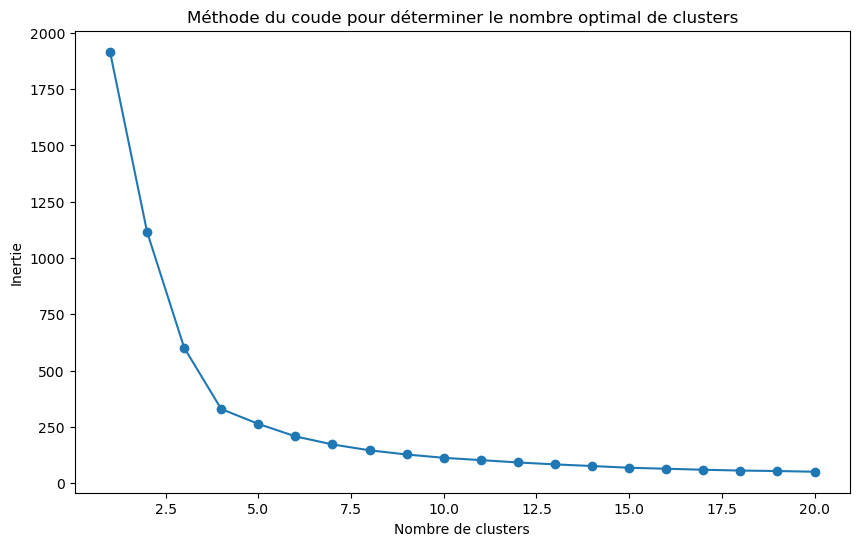

In [22]:
#IDENTIFIER LE MEILLEUR NB DE CLUSTER

from sklearn.cluster import KMeans

# Liste pour stocker les valeurs de l'inertie
inertia = []

# Nombre de clusters que vous souhaitez tester
max_clusters = 20

for n_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


# Tracer le graphique de l'inertie en fonction du nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.savefig(myouputpath + 'Clust_1_curve.png')
mlflow.log_artifact(myouputpath + 'Clust_1_curve.png', "Clust_1_curve")
plt.show()

0    958.0
Name: Cluster2, dtype: float64


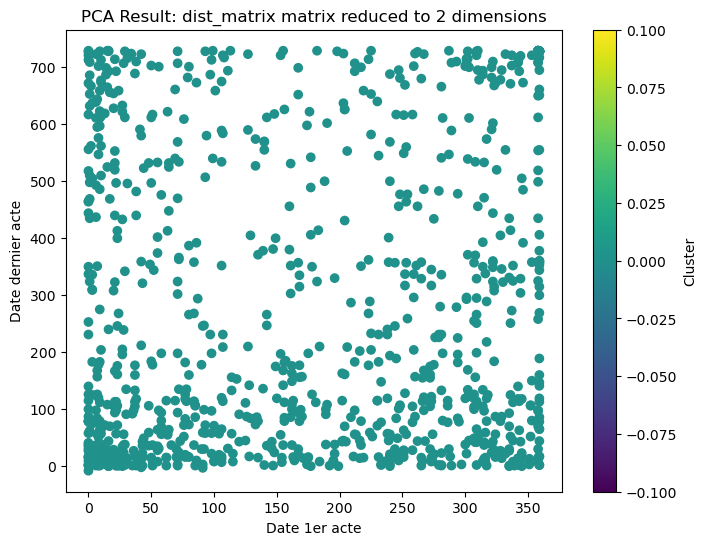

In [23]:
n_clusters1 = 1  # Choose the number of clusters you want

mlflow.log_params({'nb_clust1': n_clusters1})


#APPLY CLUSTERING AGGLOMERATIVE
#from sklearn.cluster import AgglomerativeClustering
#clust = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

#APPLY CLUSTERING KMEANS
from sklearn.cluster import KMeans
clust = KMeans(n_clusters=n_clusters1)



labels = clust.fit_predict(X_scaled)
Labels_duplicated=[]

for i in range(len(labels)):
    for k in range(int(Aggreg_Patients['Nb_dim'])):
        Labels_duplicated.append(labels[i])
    
#Applique le n° de CLUSTER aux dataset initiaux
#data_to_plot['Cluster']=labels
Aggreg_Patients['df']['Cluster2']=Labels_duplicated

#show how the clusters are populated
#data_to_plot['Cluster'].value_counts().sort_index()
cluster_counts = Aggreg_Patients['df']['Cluster2'].value_counts().sort_index()
cluster_counts_divided = cluster_counts.divide(int(Aggreg_Patients['Nb_dim']))
print(cluster_counts_divided)

#import numpy as np
#from sklearn.decomposition import PCA
#import matplotlib.pyplot as plt


#labels   # Example cluster labels, replace this with your actual cluster labels

# Plotting the PCA result with cluster colors
plt.figure(figsize=(8, 6))
plt.scatter(DDA_Clust['DPA_NIP'], DDA_Clust['DDA_NIP'], c=labels, cmap='viridis')
plt.title('PCA Result: dist_matrix matrix reduced to 2 dimensions')
plt.xlabel('Date 1er acte')
plt.ylabel('Date dernier acte')
plt.colorbar(label='Cluster')
plt.savefig(myouputpath + 'Clust_1_shape.png')
mlflow.log_artifact(myouputpath + 'Clust_1_shape.png', "Clust_1_2D")
plt.show()

SECOND CLUSTERING :
CLUSTERING ON THE RESULT OF DISTANCE TIME SERIES

In [24]:
# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dist_matrix)

In [25]:
#from sklearn.decomposition import PCA
#import matplotlib.pyplot as plt

# Initialize PCA
#pca = PCA()
#pca_result = pca.fit_transform(X_scaled)

# Get explained variance ratio
#explained_var = pca.explained_variance_ratio_

# Plotting explained variance ratio
#plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
#plt.xlabel('Number of Components')
#plt.ylabel('Explained Variance Ratio')
#plt.title('PCA - Explained Variance Ratio')
#plt.show()

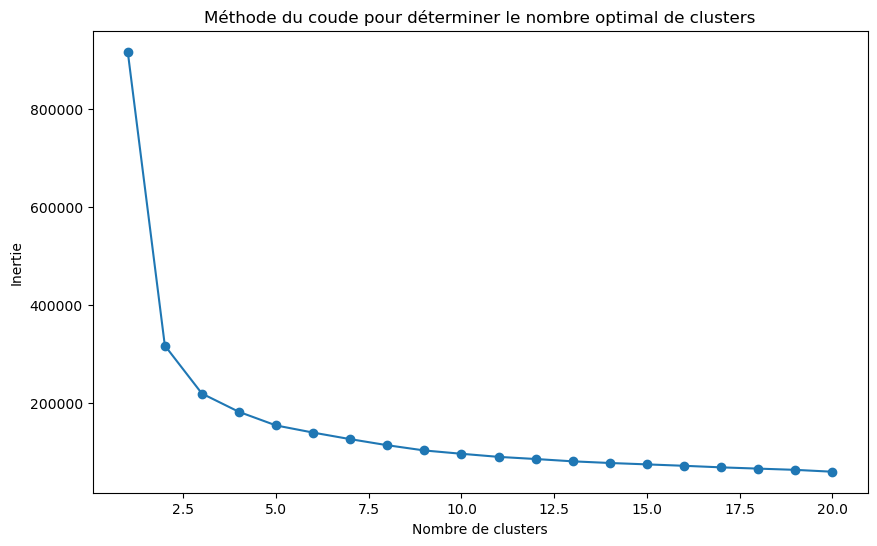

In [26]:
#IDENTIFIER LE MEILLEUR NB DE CLUSTER

from sklearn.cluster import KMeans

# Liste pour stocker les valeurs de l'inertie
inertia = []

# Nombre de clusters que vous souhaitez tester
max_clusters = 20

for n_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


# Tracer le graphique de l'inertie en fonction du nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.savefig(myouputpath + 'Clust_2_curve.png')
mlflow.log_artifact(myouputpath + 'Clust_2_curve.png', "Clust_2_curve")
plt.show()

   Cluster  NIP_Count  Mean_dist_Variance
0        0        642            2.380327
1        1        253           20.856844
2        2         14          164.742279
3        3         49           20.537015


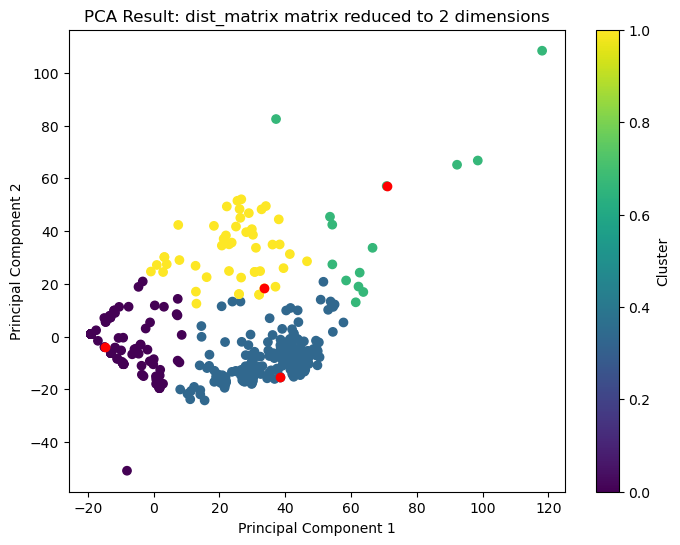

In [27]:
n_clusters2 = 4  # Choose the number of clusters you want


#APPLY CLUSTERING AGGLOMERATIVE
#from sklearn.cluster import AgglomerativeClustering
#clust = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')

#APPLY CLUSTERING KMEANS
from sklearn.cluster import KMeans
clust = KMeans(n_clusters=n_clusters2)


from sklearn.mixture import GaussianMixture
#clust = GaussianMixture(n_components=n_clusters)  # No n_components specified
#clust = GaussianMixture(n_components=10, covariance_type='tied')

labels = clust.fit_predict(X_scaled)


#Applique le n° de CLUSTER aux dataset initiaux

Labels_duplicated=[]

for i in range(len(labels)):
    for k in range(int(Aggreg_Patients['Nb_dim'])):
        Labels_duplicated.append(labels[i])
    
Aggreg_Patients['df']['Cluster']=Labels_duplicated

cluster_means = Aggreg_Patients['df'].groupby('Cluster').mean()
cluster_var = Aggreg_Patients['df'].groupby('Cluster').sem()

#Compute the clusters description and define the 'mean individual'

# Get the "mean individual" from each cluster.
df_dist_matrix = pd.DataFrame(dist_matrix)
df_dist_matrix['Cluster'] = labels
df_dist_matrix['NIP'] = Aggreg_Patients['df']['NIP']
df_dist_matrix['Mean_Indiv'] = False


for cluster in range(n_clusters2):
    # Extract a part of the dist matrix
    cluster_subset = df_dist_matrix[df_dist_matrix['Cluster'] == cluster]

    # Compute the mean distance for each row in the cluster and store it in the 'Mean_dist' column
    df_dist_matrix.loc[df_dist_matrix['Cluster'] == cluster, 'Mean_dist'] = cluster_subset.drop(['Cluster', 'NIP', 'Mean_Indiv'], axis=1).mean(axis=1)

    # Calculate the mean of the distances within the cluster
    mean_distance = df_dist_matrix[df_dist_matrix['Cluster'] == cluster]['Mean_dist'].mean()

    # Find the index of the row closest to the mean distance
    mean_row_mean_index = df_dist_matrix[df_dist_matrix['Cluster'] == cluster]['Mean_dist'].sub(mean_distance).abs().idxmin()

    # Update 'Mean_Indiv' to True for the row with the minimum mean distance
    df_dist_matrix.at[mean_row_mean_index, 'Mean_Indiv'] = True

# Creating the Clustering_summary DataFrame
# Group by 'Cluster' and calculate count of 'NIP' and variance of 'Mean_dist'
summary_data = df_dist_matrix.groupby('Cluster').agg({'NIP': 'count', 'Mean_dist': 'var'}).reset_index()
summary_data.columns = ['Cluster', 'NIP_Count', 'Mean_dist_Variance']

# Creating the Clustering_summary DataFrame
Clustering_summary = summary_data.copy()

# Displaying the summary DataFrame
print(Clustering_summary)

#import numpy as np
#from sklearn.decomposition import PCA
#import matplotlib.pyplot as plt


#labels   # Example cluster labels, replace this with your actual cluster labels
# Assuming dist_matrix is your 50x50 matrix
# Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
pca_result = pca.fit_transform(X_scaled)


indices_to_highlight=df_dist_matrix.loc[df_dist_matrix['Mean_Indiv'] == True].index


# Plotting the PCA result with cluster colors
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis')
plt.scatter(pca_result[indices_to_highlight, 0], 
            pca_result[indices_to_highlight, 1], 
            c='red', label='Highlighted Points')

plt.title('PCA Result: dist_matrix matrix reduced to 2 dimensions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.savefig(myouputpath + 'Clust_2_shape.png')
plt.show()




In [28]:
#Store to mlflow important values
mlflow.log_params({'nb_clust2': n_clusters2})
mlflow.log_artifact(myouputpath + 'Clust_2_shape.png', "Clust_2_2D")

cluster_means.to_csv(myouputpath + 'Cluster_means.csv')
cluster_var.to_csv(myouputpath + 'Cluster_var.csv')

mlflow.log_artifact(myouputpath + 'Cluster_means.csv', 'cluster means')
mlflow.log_artifact(myouputpath + 'Cluster_var.csv','cluster var')
mlflow.log_table(Clustering_summary,'cluster summary')

df_dist_matrix.to_excel(myouputpath + 'DF_dist_matrix.xlsx')
mlflow.log_artifact(myouputpath + 'DF_dist_matrix.xlsx', 'DF_dist_matrix.xlsx')

In [29]:
# PLOT CLUSTERS

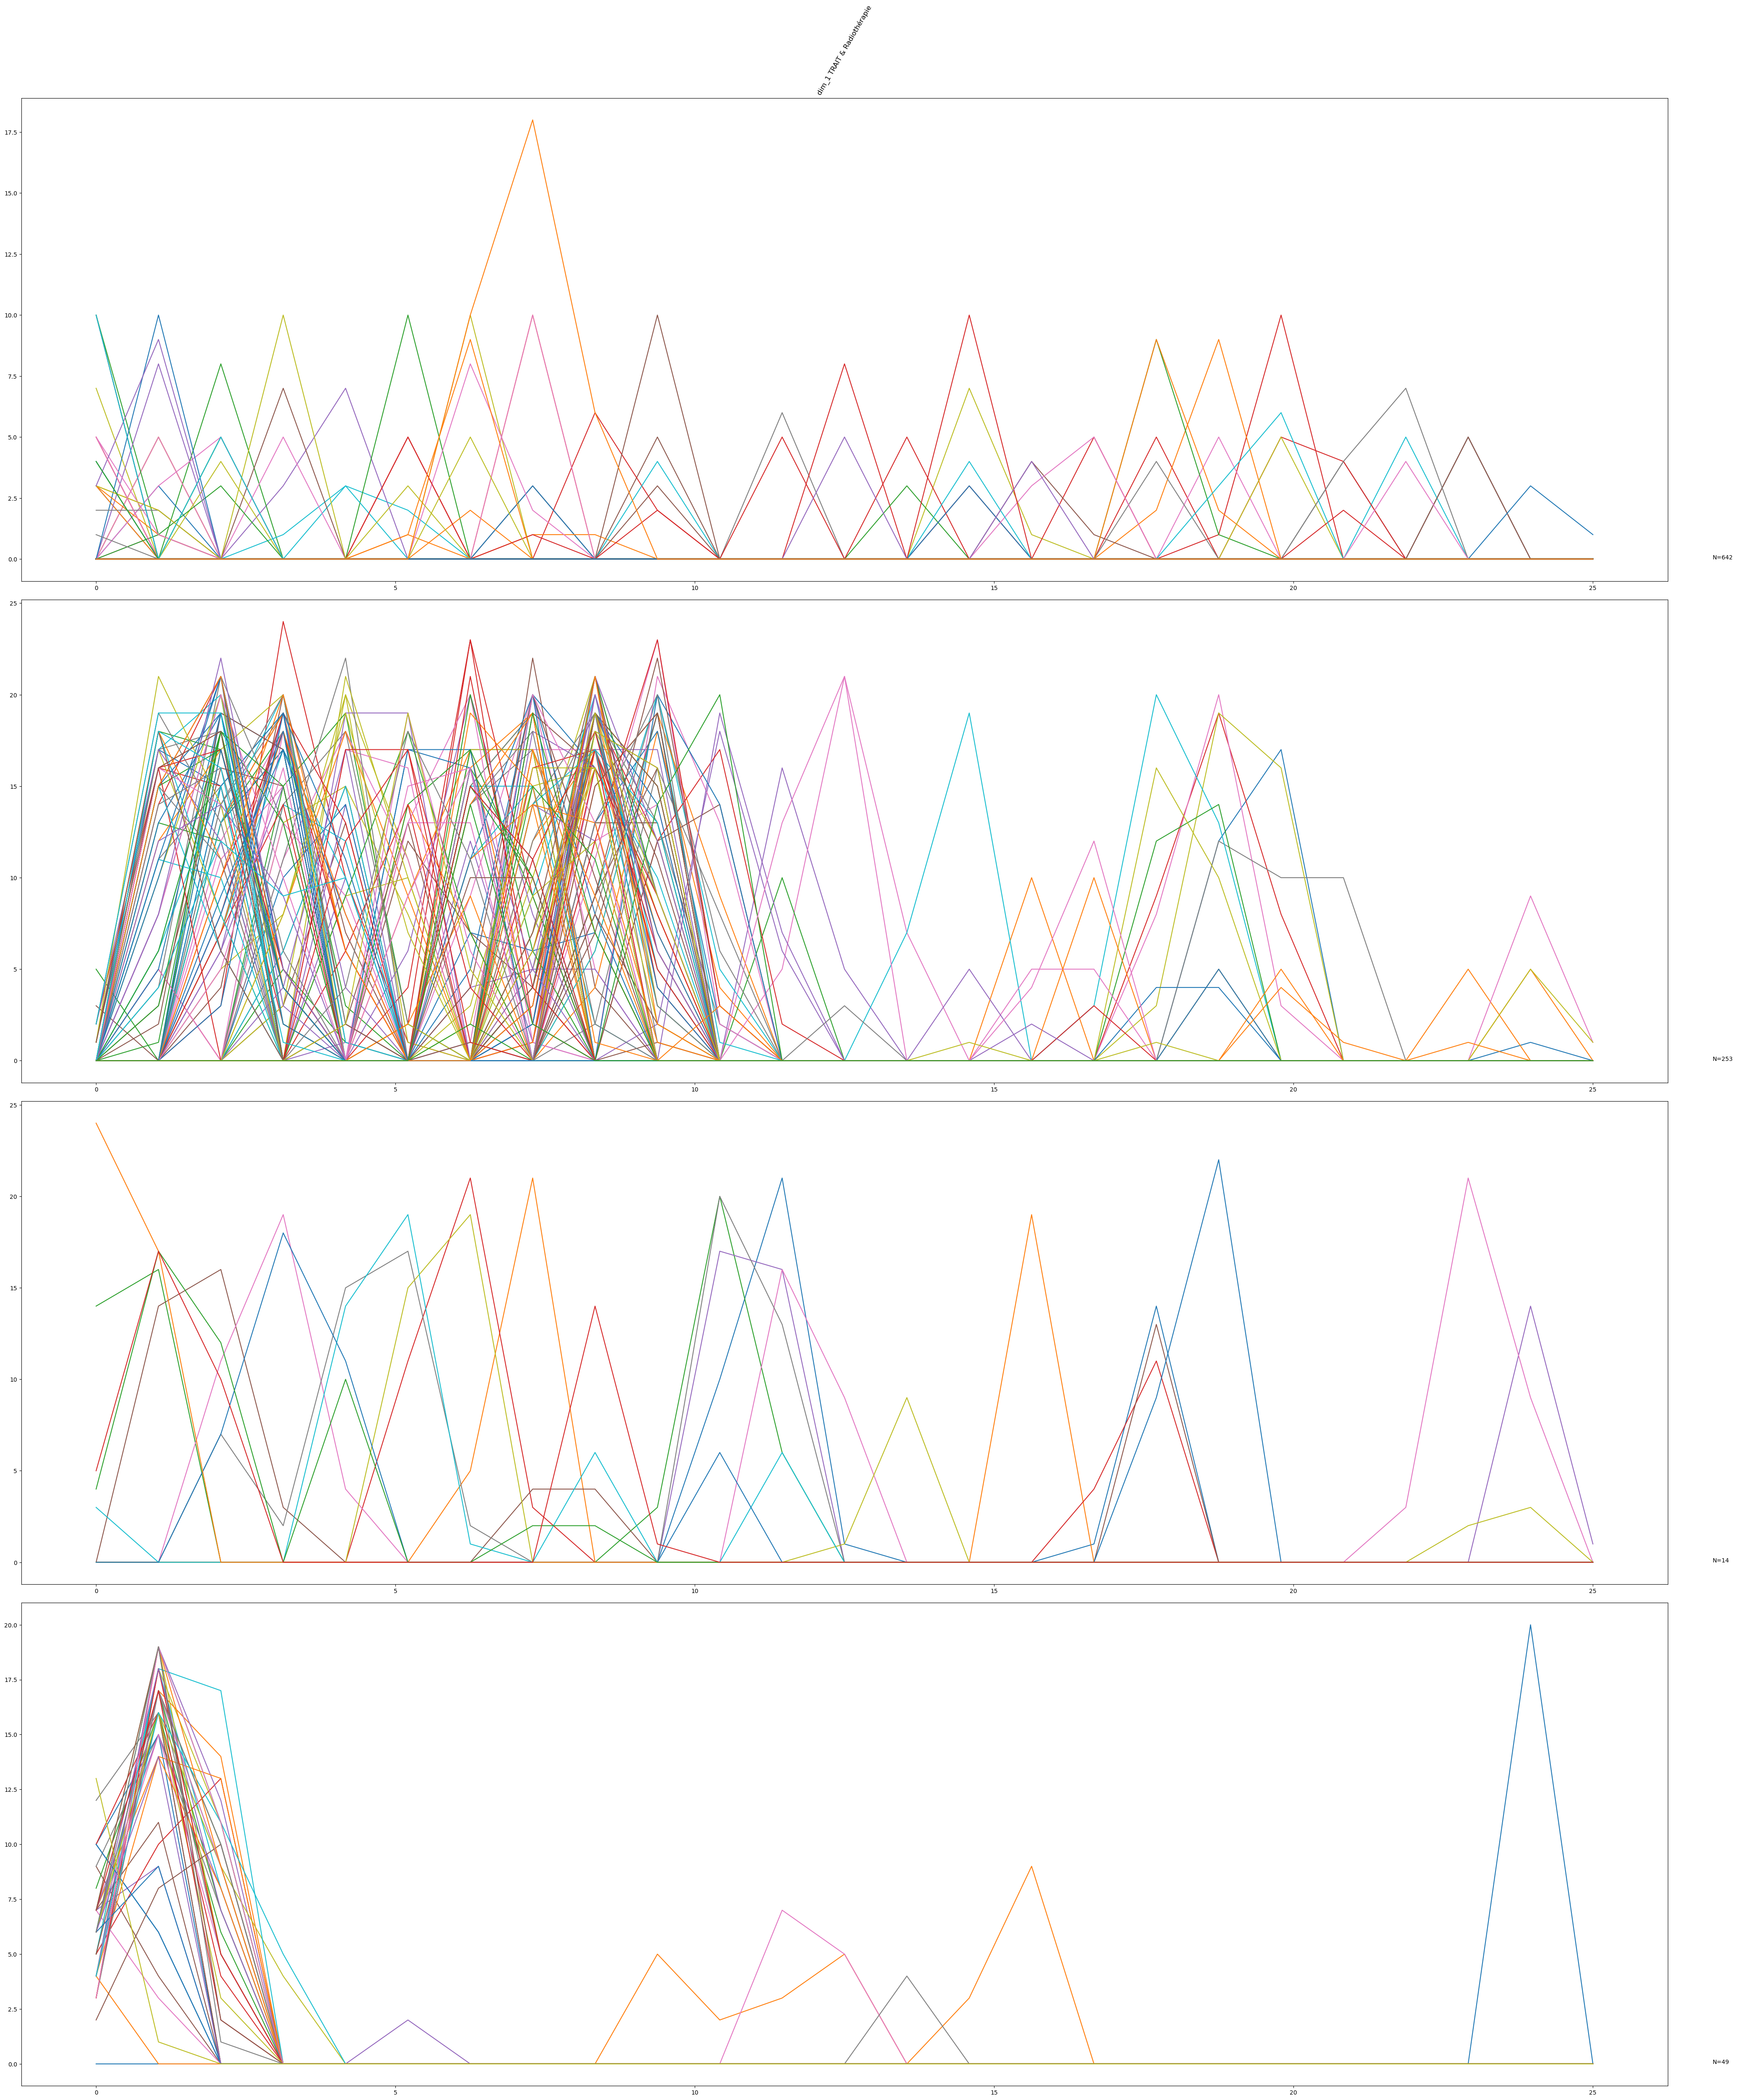

In [30]:
Mcftsc.plot_TS_clusters(Aggreg_Patients,Aggreg_parameters,myouputpath+ 'TS_curves.png',n_clusters2 )


In [31]:
# PLOT MEAN INDIVIDUAL

ORDER THE CAREPATHES BY TIME
UNE ALTERNATIVE SERAIT DE PRENDRE LE PARCOURS MOYEN DU CLUSTER ET DE CLASSER PAR DISTANCE D'ECART AU PARCOURS MOYEN.

In [32]:
df_time_feature1=pd.merge(df_Actes_graph[['NIP','J_Parcours_V1','J_Parcours_V3']],Aggreg_Patients['df'][['NIP','Cluster','Cluster2']], on='NIP',how='left')
df_time_feature1=df_time_feature1.sort_values(by=['Cluster','Cluster2','J_Parcours_V3','NIP']).copy()
df_time_feature1[['NIP','J_Parcours_V1','J_Parcours_V3']]
df_time_feature1

NIP  J_Parcours_V1  J_Parcours_V3  Cluster  Cluster2
22169   N201800012              0              0        0         0
22198   N201800012              0              0        0         0
152608  N201800036              0              0        0         0
161709  N201800036              0              0        0         0
161710  N201800036              0              0        0         0
...            ...            ...            ...      ...       ...
82726   N201602241           1009           1566        3         0
89882   N201602241           1009           1566        3         0
89883   N201602241           1009           1566        3         0
141048  N201602241           1009           1566        3         0
146607  N201602241           1009           1566        3         0

[172052 rows x 5 columns]

In [33]:
agg_functions_max = { 
    'J_Parcours_V1': 'max',
    'J_Parcours_V3': 'max',
    'Cluster': 'max',
    'Cluster2': 'max'
}
agg_functions_min = { 
    'J_Parcours_V1': 'min',
    'J_Parcours_V3': 'min',
}
df_time_feature_max = df_time_feature1.groupby('NIP').agg(agg_functions_max)
df_time_feature_max = df_time_feature_max.rename(columns={'J_Parcours_V1': 'Max_J_V1','J_Parcours_V3': 'Max_J_V3'})

df_time_feature_min = df_time_feature1[['NIP','J_Parcours_V1','J_Parcours_V3']].groupby('NIP').agg(agg_functions_min)
df_time_feature_min = df_time_feature_min.rename(columns={'J_Parcours_V1': 'Min_J_V1','J_Parcours_V3': 'Min_J_V3'})
df_time_feature1 = pd.concat([df_time_feature_min, df_time_feature_max], axis=1)

df_time_feature1

Min_J_V1  Min_J_V3  Max_J_V1  Max_J_V3  Cluster  Cluster2
NIP                                                                  
N198300511         0     12886       791     13677        0         0
N198302025         0     12731       924     13655        0         0
N198302546         0     12809       161     12970        0         0
N198403316         0     12289       994     13283        0         0
N198412339         0     12384       570     12954        0         0
...              ...       ...       ...       ...      ...       ...
N201900040         0         0       615       615        1         0
N201900041         0         0       459       459        0         0
N201900042         0         0       684       684        0         0
N201900043         0         0       609       609        1         0
N201900044         0         0       663       663        0         0

[958 rows x 6 columns]

In [34]:
#Ordonner le dataset
df_time_feature1['NIP']=df_time_feature1.index
df_time_feature1.reset_index(drop=True, inplace=True)
df_time_feature1.sort_values(['Cluster','Cluster2', 'Max_J_V1'], ascending=[True,True, False], inplace=True)

In [35]:
# Creation de l'abscisee du graph

Nb_NIP=len(df_time_feature1)

#First STEP
old_NIP=''
old_Cluster=-1
old_Cluster2=-1
x_values=[]
xx_values=[]
x=0
NIP_Step = 100/Nb_NIP

for index,row in df_time_feature1.iterrows():
    
    if old_Cluster!=row['Cluster']:
        x += NIP_Step
        x_values.append(x)  #crée une nouvelle ligne verticale de Cluster N1
        df_time_feature1.at[index,'X_abscisse']=x
    elif old_Cluster2!=row['Cluster2']:
        x += NIP_Step
        xx_values.append(x) #crée une nouvelle ligne verticale de Cluster N2
        df_time_feature1.at[index,'X_abscisse']=x
    else:    
        x += NIP_Step
        df_time_feature1.at[index,'X_abscisse']=x
       


    df_time_feature1.at[index,'X_abscisse']=x
    old_NIP=row['NIP']
    old_Cluster=row['Cluster']
    old_Cluster2=row['Cluster2']

# Afficher le DataFrame avec les abscisses calculées
df_time_feature1

Min_J_V1  Min_J_V3  Max_J_V1  Max_J_V3  Cluster  Cluster2         NIP  \
123         0      3479      1087      4566        0         0  N200804686   
80          0      4940      1086      6026        0         0  N200401716   
75          0      5306      1085      6391        0         0  N200304007   
482         0         0      1085      1085        0         0  N201800012   
186         0      2024      1080      3104        0         0  N201203100   
..        ...       ...       ...       ...      ...       ...         ...   
761         0         0       140       140        3         0  N201805939   
830         0         0        79        79        3         0  N201806582   
768         0         0        71        71        3         0  N201806047   
791         0         0        71        71        3         0  N201806314   
814         0         0        50        50        3         0  N201806486   

     X_abscisse  
123    0.104384  
80     0.208768  
75     0.313152  
482    0.417537  
186    0.521921  
..          ...  
761   99.582463  
830   99.686848  
768   99.791232  
791   99.895616  
814  100.000000  

[958 rows x 8 columns]

In [36]:
#Sauvegarder dans la BDD l'association NIP - Cluster
Table_Cluster='Tmp_NIP_Cluster' 
Requete = 'EXECUTE dbo.Delete_Table_if_exists ' + Table_Cluster
with AlSQL.engine.begin() as conn:
            conn.execute(sqlalchemy.text(Requete))
df_time_feature1[['NIP','Cluster','Cluster2','X_abscisse']].to_sql(Table_Cluster,AlSQL.engine)

df_time_feature1[['NIP','Cluster','Cluster2','X_abscisse']].to_csv(myouputpath + 'Cluster1_2_abscisses.csv')
mlflow.log_artifact(myouputpath + 'Cluster1_2_abscisses.csv', "Cluster Ouput")

2023-12-13 21:47:08,941 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-13 21:47:08,942 INFO sqlalchemy.engine.Engine EXECUTE dbo.Delete_Table_if_exists Tmp_NIP_Cluster
2023-12-13 21:47:08,943 INFO sqlalchemy.engine.Engine [generated in 0.00120s] ()
2023-12-13 21:47:08,948 INFO sqlalchemy.engine.Engine COMMIT
2023-12-13 21:47:08,955 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME], [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max))
2023-12-13 21:47:08,956 INFO sqlalchemy.engine.Engine [generated in 0.00093s] ('Tmp_NIP_Cluster', 'dbo')
2023-12-13 21:47:08,964 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-13 21:47:08,965 INFO sqlalchemy.engine.Engine 
CREATE TABLE [Tmp_NIP_Cluster] (
	[index] BIGINT NULL, 
	[NIP] VARCHAR(max) NULL, 
	[Cluster] INTEGER NULL, 
	[Clu

2023-12-13 21:47:09,539 INFO sqlalchemy.engine.Engine SELECT Table_Acte.[NIP]
	  ,Table_Cluster.Cluster
	  ,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 , [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  WHERE Table_Cluster.NIP = Table_Acte.NIP
        AND Table_Acte.[Phase]='Traitement'
  ORDER BY Table_Cluster.Cluster asc ,Table_Acte.[J_Parcours_V1] desc, Table_Acte.[NIP]

2023-12-13 21:47:09,540 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


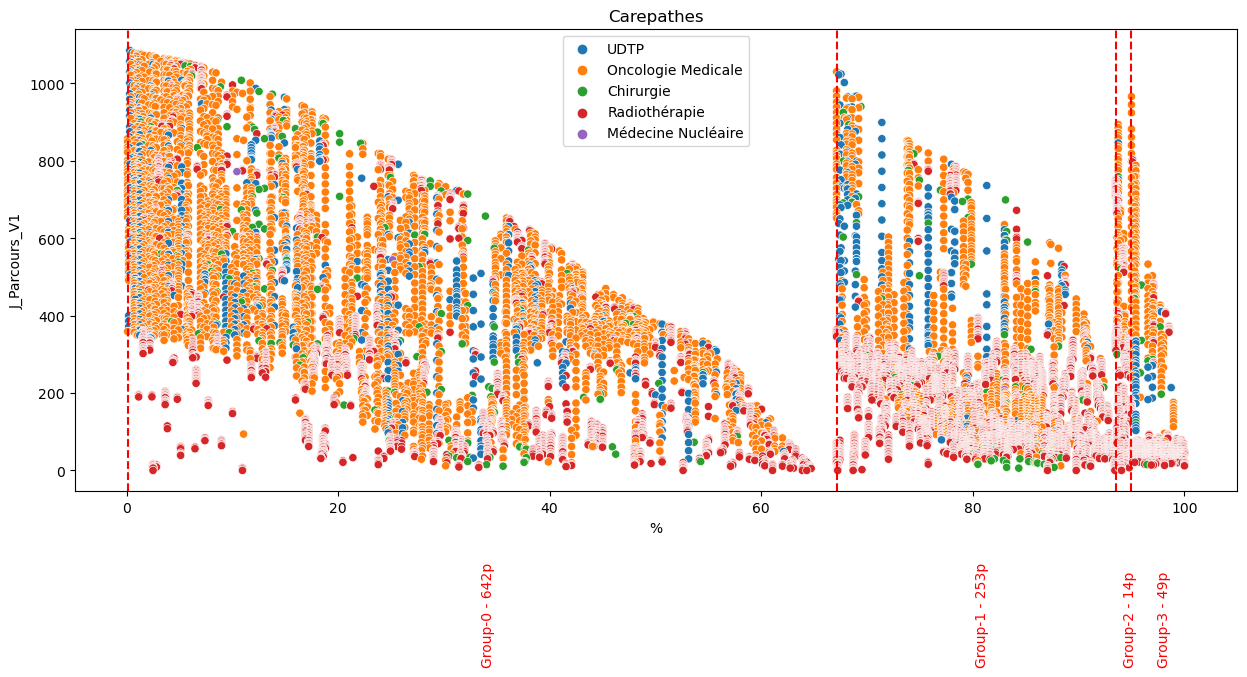

In [37]:
#Recuperer une table acte avec les clusters
Requete="""SELECT Table_Acte.[NIP]
	  ,Table_Cluster.Cluster
	  ,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 , [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  WHERE Table_Cluster.NIP = Table_Acte.NIP
        AND Table_Acte.[Phase]='Traitement'
  ORDER BY Table_Cluster.Cluster asc ,Table_Acte.[J_Parcours_V1] desc, Table_Acte.[NIP]
"""
df_Actes_graph2=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')


fig, axs = plt.subplots(1, 1, figsize=(15, 6))
axs.set_title('Carepathes')
scatter=sns.scatterplot(data=df_Actes_graph2, x=df_Actes_graph2.X_abscisse, y='J_Parcours_V1',markers='Activite', hue='Service')

# Changing X and Y axis labels
scatter.set_xlabel('%')  # Change X axis label
scatter.set_ylabel('J_Parcours_V1')  # Change Y axis label

# Ajoutez la ligne verticale
for x_value in x_values:
    axs.axvline(x=x_value, color='red', linestyle='--') #, label=f'Vertical Line at x={x_value}')

# Ajoutez la ligne verticale
for xx_value in xx_values:
    axs.axvline(x=xx_value, color='green', linestyle='-.') #, label=f'Vertical Line at x={x_value}')

#Ajouter le n° de cluster + sa taille*
pop_clust=df_time_feature1['Cluster'].value_counts().sort_index()
x_text=[0]*n_clusters2

for n_clus in range(n_clusters2):    
    if n_clus==0 :
        x_text[n_clus]=NIP_Step * pop_clust[n_clus] / 2
    else:
        x_text[n_clus]=x_text[n_clus-1] + NIP_Step*(pop_clust[n_clus-1] + pop_clust[n_clus])/2
    y_text=(-500)
    axs.text(x_text[n_clus], y_text, 'Group-' + str(n_clus) + " - " + str(pop_clust[n_clus]) +"p", color='red', rotation=90)
    

# Vous pouvez personnaliser la couleur, le style de ligne, et ajouter une légende
axs.legend()

#Enregistre le graph dans mlflow.
plt.savefig(myouputpath + 'Parcours_clustered_shape.png')
mlflow.log_artifact(myouputpath + 'Parcours_clustered_shape.png', "Carepath_Clustered")

plt.show()

#axs.flat[1].set_title('ratings_count boxplot')
#sns.boxplot(data=df, x='ratings_count', ax=axs[1])

In [38]:
# CLOSE THE MLFLOW
mlflow.end_run()